## Rover Project Test Notebook
This notebook contains the functions from the lesson and provides the scaffolding you need to test out your mapping methods.  The steps you need to complete in this notebook for the project are the following:

* Run the simulator in "Training Mode" and record some data.  
* Change the data directory path (2 cells below) to be the directory where you saved data
* Test out the functions provided on your data
* Write new functions (or modify existing ones) to report and map out detections of obstacles and rock samples (yellow rocks)
* Populate the `process_image()` function with the appropriate steps/functions to go from a raw image to a worldmap.
* Run the cell that calls `process_image()` using `moviepy` functions to create video output
* Satisfied with your map?  Move on to modifying `perception.py` and `decision.py` to allow your rover to navigate and map in autonomous mode!

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

**Run the next cell to get code highlighting in the markdown cells.**

In [2]:
%%HTML
<style> code {background-color : orange !important;} </style>

In [3]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder

## Quick Look at the Data
Read in and display a random image from the `test_dataset` folder

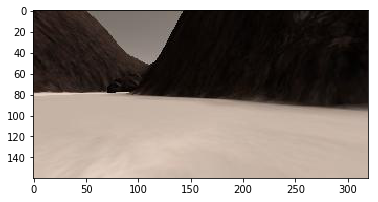

In [4]:
path = '../test_dataset/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

## Calibration Data
Read in and display example grid and rock sample calibration images.  You'll use the grid for perspective transform and the rock image for creating a new color selection that identifies these samples of interest. 

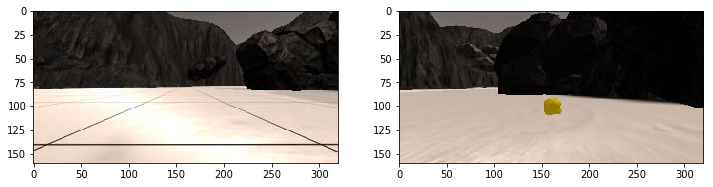

In [5]:
# In the simulator you can toggle on a grid on the ground for calibration
# You can also toggle on the rock samples with the 0 (zero) key.  
# Here's an example of the grid and one of the rocks
example_grid = '../calibration_images/example_grid1.jpg'
example_rock = '../calibration_images/example_rock1.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

## Perspective Transform

Define the perspective transform function from the lesson and test it on an image.

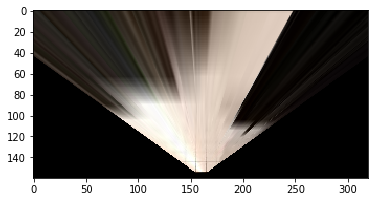

In [16]:
# Define a function to perform a perspective transform
# I've used the example grid image above to choose source points for the
# grid cell in front of the rover (each grid cell is 1 square meter in the sim)
# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):
           
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    
    return warped


# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
# The destination box will be 2*dst_size on each side
dst_size = 5 
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
# this is just a rough guess, feel free to change it!
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
warped = perspect_transform(rock_img, source, destination)
warped = perspect_transform(grid_img, source, destination)

plt.imshow(warped)
#scipy.misc.imsave('../output/warped_example.jpg', warped)

## Color Thresholding
Define the color thresholding function from the lesson and apply it to the warped image

**TODO:** Ultimately, you want your map to not just include navigable terrain but also obstacles and the positions of the rock samples you're searching for.  Modify this function or write a new function that returns the pixel locations of obstacles (areas below the threshold) and rock samples (yellow rocks in calibration images), such that you can map these areas into world coordinates as well.  
**Suggestion:** Think about imposing a lower and upper boundary in your color selection to be more specific about choosing colors.  Feel free to get creative and even bring in functions from other libraries.  Here's an example of [color selection](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html) using OpenCV.  
**Beware:** if you start manipulating images with OpenCV that it defaults to `BGR` instead of `RGB` color space when reading/writing images, so things can get confusing.

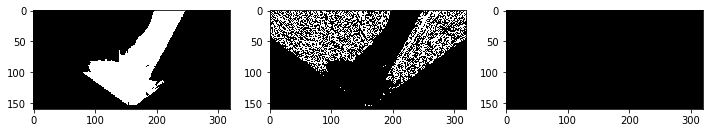

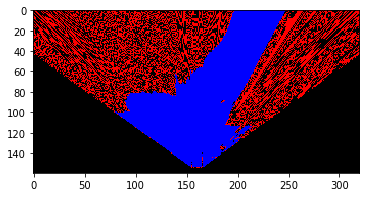

In [17]:
# Identify pixels above the threshold
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    color_unselect = np.ones_like(img[:,:,0])
    color_unselect[above_thresh] = 0
    
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    obstacle = np.bitwise_and(color_unselect, img_gray)
    # Return the binary image
    return color_select, obstacle#color_unselect


def color_thresh_rock(img):
#     img = cv2.imread(img)
    # convert color space
    img_bgr = img[..., : : -1]
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    
    # define range of yellow color in HSV
    lower_yellow = np.array([20,100,100])
    upper_yellow = np.array([30,255,255])
    
    # Threshold the HSV image to get only yellow colors
    mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    mask = mask > 0
    
    color_select = np.zeros_like(img[:,:,0])
    color_select[mask] = 1
    return color_select

threshed, underThreshold = color_thresh(warped)
rock_sample = color_thresh_rock(warped)#rock_img)

fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.imshow(threshed, cmap='gray')
plt.subplot(132)
plt.imshow(underThreshold, cmap='gray')
plt.subplot(133)
plt.imshow(rock_sample, cmap='gray')

# split rock from obstacles
obstacles = rock_sample ^ underThreshold
threshed = rock_sample ^ threshed

# obstacles *= 255
# threshed *= 255
# rock_sample *= 255
# print(rock_sample)
# print(obstacles)
# print(threshed)

vision_image = np.zeros((160, 320, 3), dtype=np.float)
vision_image[:,:,0] = obstacles#np.maximum(obstacles, rock_sample)
vision_image[:,:,1] = rock_sample
vision_image[:,:,2] = threshed

# mapping_3d = np.dstack((threshed*255+rock_sample*255, rock_sample*255, obstacles*255)).astype(np.float)
fig = plt.figure(figsize=(12,3))

plt.imshow(vision_image)
#scipy.misc.imsave('../output/warped_threshed.jpg', threshed*255)

## Coordinate Transformations
Define the functions used to do coordinate transforms and apply them to an image.

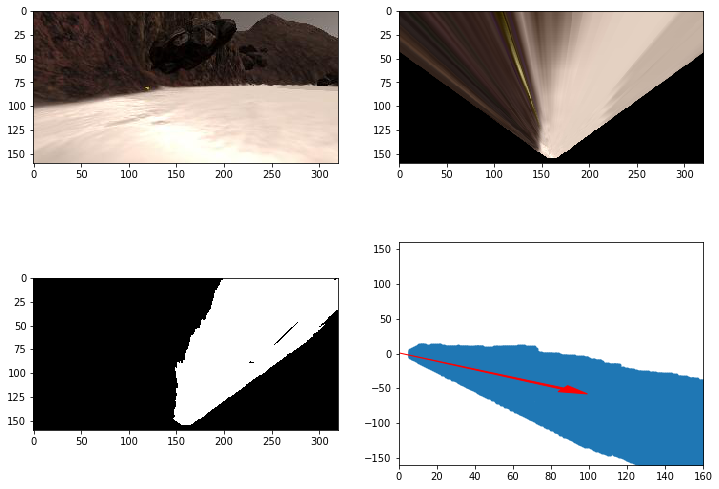

In [11]:
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = np.absolute(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[0]).astype(np.float)
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to map rover space pixels to world space
def pix_to_world(xpix, ypix, x_rover, y_rover, yaw_rover, world_size, scale):
    # Map pixels from rover space to world coords
    yaw = yaw_rover * np.pi / 180
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_((((xpix * np.cos(yaw)) - (ypix * np.sin(yaw)))/scale) + x_rover), 
                            0, world_size - 1)
    y_pix_world = np.clip(np.int_((((xpix * np.sin(yaw)) + (ypix * np.cos(yaw)))/scale) + y_rover), 
                            0, world_size - 1)
  
    return x_pix_world, y_pix_world

# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped = perspect_transform(image, source, destination)
threshed, obstacles = color_thresh(warped)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshed, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)

rover_xpos = np.random.random(1)*160 + 20
rover_ypos = np.random.random(1)*160 + 20
rover_yaw = np.random.random(1)*360


## Read in saved data and ground truth map of the world
The next cell is all setup to read your saved data into a `pandas` dataframe.  Here you'll also read in a "ground truth" map of the world, where white pixels (pixel value = 1) represent navigable terrain.  

After that, we'll define a class to store telemetry data and pathnames to images.  When you instantiate this class (`data = Databucket()`) you'll have a global variable called `data` that you can refer to for telemetry and map data within the `process_image()` function in the following cell.  


In [18]:
# Import pandas and read in csv file as a dataframe
import pandas as pd
# Change this path to your data directory
# df = pd.read_csv('../test_dataset/robot_log.csv')
df = pd.read_csv('/Users/LuQiang/Downloads/rover_dataset/robot_log.csv')

img_list_sorted = df["Path"].tolist() # Create list of image pathnames
# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth, ground_truth*0)).astype(np.float)

# Creating a class to be the data container
# Will read in saved data from csv file and populate this object
# Worldmap is instantiated as 200 x 200 grids corresponding 
# to a 200m x 200m space (same size as the ground truth map: 200 x 200 pixels)
# This encompasses the full range of output position values in x and y from the sim
class Databucket():
    def __init__(self):
        self.images = img_list_sorted  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = 0
        self.worldmap = ground_truth_3d * 255#np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap

# Instantiate a Databucket().. this will be a global variable/object
# that you can refer to in the process_image() function below
data = Databucket()
# data.worldmap = data.ground_truth * 255 * 0.5


## Write a function to process stored images

Modify the `process_image()` function below by adding in the perception step processes (functions defined above) to perform image analysis and mapping.  The following cell is all set up to use this `process_image()` function in conjunction with the `moviepy` video processing package to create a video from the images you saved taking data in the simulator.  

In short, you will be passing individual images into `process_image()` and building up an image called `output_image` that will be stored as one frame of video.  You can make a mosaic of the various steps of your analysis process and add text as you like (example provided below).  



To start with, you can simply run the next three cells to see what happens, but then go ahead and modify them such that the output video demonstrates your mapping process.  Feel free to get creative!

In [19]:
# Define a function to pass stored images to
# reading rover position and yaw angle from csv file
# This function will be used by moviepy to create an output video
def process_image1(img):
    
    # Example of how to use the Databucket() object defined in the previous cell
    # print(data.xpos[0], data.ypos[0], data.yaw[0])
    warped = perspect_transform(img, source, destination)
    threshed, underThreshold = color_thresh(warped)
    rock_sample = color_thresh_rock(warped)

    # split rock from obstacles
    obstacles = rock_sample ^ underThreshold
    threshed = rock_sample ^ threshed
    vision_image = np.zeros((160, 320, 3), dtype=np.float)
    vision_image[:,:,0] = obstacles*255#np.maximum(obstacles, rock_sample)
    vision_image[:,:,1] = rock_sample*255
    vision_image[:,:,2] = threshed*255    
    
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
    # Example
   
    xpix, ypix = rover_coords(threshed)
    rock_xpix, rock_ypix = rover_coords(rock_sample)
    obstacles_xpix, obstacles_ypix = rover_coords(obstacles)

#     # Convert rover-centric pixel values to world coordinates
#     scale = 10
    
#     if data.count >= len(data.images):
#         data.count = len(data.images) - 1
#     rover_xpos, rover_ypos = data.xpos[data.count], data.ypos[data.count]
#     rover_yaw = data.yaw[data.count]
# #     print(data.count, data.xpos[data.count])
    
#     # Get navigable pixel positions in world coords
#     navigable_x_world, navigable_y_world = pix_to_world(xpix, ypix, rover_xpos, rover_ypos, rover_yaw, data.worldmap.shape[0], scale)

#     rock_x_world, rock_y_world = pix_to_world(rock_xpix, rock_ypix, rover_xpos,
#                                 rover_ypos, rover_yaw,
#                                 data.worldmap.shape[0], scale)

#     obstacle_x_world, obstacle_y_world = pix_to_world(obstacles_xpix, obstacles_ypix, rover_xpos,
#                                 rover_ypos, rover_yaw,
#                                 data.worldmap.shape[0], scale)
#     # 7) Update Rover worldmap (to be displayed on right side of screen)
        
#     data.worldmap[obstacle_y_world, obstacle_x_world, 0] += 1
#     data.worldmap[rock_y_world, rock_x_world, 1] += 1
#     data.worldmap[navigable_y_world, navigable_x_world, 2] += 1

    output_image[0:img.shape[0], 0:img.shape[1]] = img
    output_image[0:img.shape[0], img.shape[1]:] = warped
#     map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth*255, 0.5, 0)
#     map_add = data.worldmap + data.ground_truth * 255 / 2
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = ground_truth_3d * 255
    output_image[img.shape[0]:img.shape[0] + 160, img.shape[1]:] = vision_image
    cv2.putText(output_image,"Populate this image with your analyses to make a video!", (20, 20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    data.count += 1 # Keep track of the index in the Databucket()
    return output_image

In [32]:
# Define a function to pass stored images to
# reading rover position and yaw angle from csv file
# This function will be used by moviepy to create an output video
def process_image(img):
    
    # Example of how to use the Databucket() object defined in the previous cell
    # print(data.xpos[0], data.ypos[0], data.yaw[0])
    warped = perspect_transform(img, source, destination)
    threshed, underThreshold = color_thresh(warped)
    rock_sample = color_thresh_rock(warped)

    # split rock from obstacles
    obstacles = rock_sample ^ underThreshold
    threshed = rock_sample ^ threshed
    vision_image = np.zeros((160, 320, 3), dtype=np.float)
    vision_image[:,:,0] = obstacles*255#np.maximum(obstacles, rock_sample)
    vision_image[:,:,1] = rock_sample*255
    vision_image[:,:,2] = threshed*255    
    
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
    # Example
   
    xpix, ypix = rover_coords(threshed)
    rock_xpix, rock_ypix = rover_coords(rock_sample)
    obstacles_xpix, obstacles_ypix = rover_coords(obstacles)

    # Convert rover-centric pixel values to world coordinates
    scale = 10
    
    if data.count >= len(data.images):
        data.count = len(data.images) - 1
    rover_xpos, rover_ypos = data.xpos[data.count], data.ypos[data.count]
    rover_yaw = data.yaw[data.count]
#     print(data.count, data.xpos[data.count])
    
    # Get navigable pixel positions in world coords
    navigable_x_world, navigable_y_world = pix_to_world(xpix, ypix, rover_xpos, rover_ypos, rover_yaw, data.worldmap.shape[0], scale)

    rock_x_world, rock_y_world = pix_to_world(rock_xpix, rock_ypix, rover_xpos,
                                rover_ypos, rover_yaw,
                                data.worldmap.shape[0], scale)

    obstacle_x_world, obstacle_y_world = pix_to_world(obstacles_xpix, obstacles_ypix, rover_xpos,
                                rover_ypos, rover_yaw,
                                data.worldmap.shape[0], scale)
    # 7) Update Rover worldmap (to be displayed on right side of screen)
        
    data.worldmap[obstacle_y_world, obstacle_x_world, 0] += 1
    data.worldmap[rock_y_world, rock_x_world, 1] += 1
    data.worldmap[navigable_y_world, navigable_x_world, 2] += 1

    output_image[0:img.shape[0], 0:img.shape[1]] = img
    output_image[0:img.shape[0], img.shape[1]:] = warped
#     map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth*255, 0.5, 0)
#     map_add = data.worldmap + data.ground_truth * 255 / 2
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = data.worldmap * 2#55#ground_truth_3d * 255
    output_image[img.shape[0]:img.shape[0] + 160, img.shape[1]:] = vision_image
    cv2.putText(output_image,"Populate this image with your analyses to make a video!", (20, 20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    data.count += 1 # Keep track of the index in the Databucket()
    return output_image

## Make a video from processed image data

The cell below is set up to read the csv file you saved along with camera images from the rover.  Change the pathname below to the location of the csv file for your data.   Also change the path to where you want to save the output video.  The ground truth map is a black and white image of a top-down view of the environment and is read in here so you can overplot your results against the ground truth.  The Python class `Databucket()` is defined here for you so you can access image and map data iteratively while processing images.   

You can gain insight into how various parameters are changing from image to image by saving them to the `Databucket()`.  For now the only thing meant for updating and saving with each iteration is `self.worldmap` where you can iteratively build your map, for example, adding navigable terrain pixels to one color channel, obstacles to another, and ground truth to another. You can add attributes to `Databucket()` if you would like to save other quantities for consideration after the processing is done.  

In [34]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip
data.count = 0
data.worldmap = data.ground_truth * 255 * 0.5

# Define pathname to save the output video
output = '../output/test_mapping.mp4'
clip = ImageSequenceClip(data.images, fps=60)
# clip.write_videofile('ss.mp4')
new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ../output/test_mapping.mp4
[MoviePy] Writing video ../output/test_mapping.mp4


100%|██████████| 2725/2725 [00:51<00:00, 53.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output/test_mapping.mp4 

CPU times: user 36.3 s, sys: 2.02 s, total: 38.3 s
Wall time: 51.6 s


In [22]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))